In [55]:
import regex as reg 
import unicodedata  
import os, re, json, html, base64
import numpy as np
import pandas as pd
from pathlib import Path
from ftfy import fix_text
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import HTML, display
from pathlib import Path
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from nltk.corpus import stopwords
import nltk

In [ ]:
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data" / "raw"
IMG_DIR  = DATA_DIR / "images" / "image_train"

X_train = pd.read_csv(DATA_DIR / "X_train_update.csv", index_col=0)
Y_train = pd.read_csv(DATA_DIR / "Y_train_CVw08PX.csv", index_col=0)

df = X_train.join(Y_train, how="inner")

In [ ]:
# Dictionnaire des catégories (prdtypecode -> libellé manuel)
categories = {
    10: "Livres techniques, éducatifs, artistiques ou spirituels",
    2705: "Romans, récits et littérature",
    2280: "Journaux, magazines et revues",
    2403: "Séries & encyclopédies",
    40: "Rétro Gaming",
    50: "Accessoires & Périphériques de Jeux Vidéo",
    60: "Consoles",
    2462: "Jeux Vidéo Modernes",
    2905: "Jeux PC en Téléchargement",
    1140: "Figurine",
    1160: "Jeu de carte à collectionner",
    1180: "Jeux de rôle & figurines",
    1280: "Jouets, Figurines et Poupées",
    1281: "Jeux éducatifs & Créatifs",
    1300: "Modélisme & Drones",
    1301: "Bébé, Jeux & Loisirs",
    1302: "Sport, Loisirs & Plein Air",
    1320: "Bébé & Puériculture",
    1560: "Équipement de la maison & décoration",
    1920: "Textiles d’intérieur",
    2060: "Décoration & Éclairage",
    2582: "Jardinage, déco & extérieur",
    2583: "Piscine & équipement de piscine",
    2585: "Jardin, Bricolage & Outillage",
    1940: "Alimentation & Épicerie",
    2220: "Animaux & Accessoires",
    2522: "Fournitures de bureau & papeterie",
}

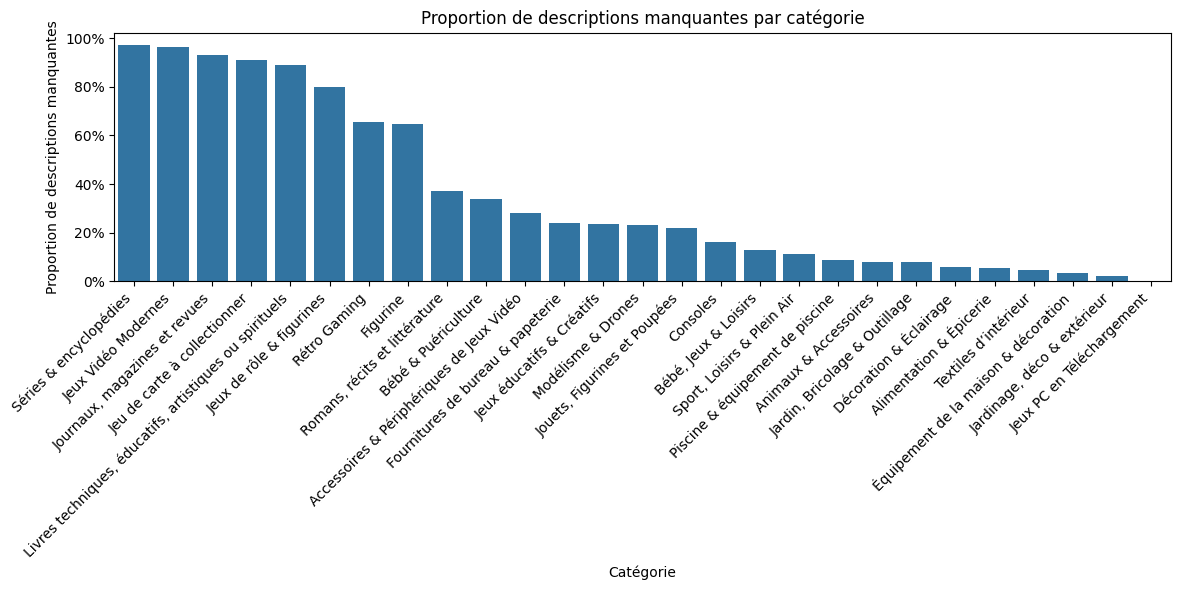

In [ ]:
# Calculer la proportion de descriptions manquantes par catégorie ('prdtypecode')
# Cell [2] : Proportion de descriptions manquantes par catégorie
missing_by_cat = (
    df.assign(description_isna=df["description"].isna())
      .groupby("prdtypecode")["description_isna"]
      .mean()
      .reset_index(name="missing_ratio")
)

missing_by_cat = missing_by_cat.sort_values("missing_ratio", ascending=False)

# Ajouter une colonne label lisible
missing_by_cat["cat_label"] = missing_by_cat["prdtypecode"].map(categories)
missing_by_cat["cat_label"] = missing_by_cat["cat_label"].fillna(
    missing_by_cat["prdtypecode"].astype(str)
)

plt.figure(figsize=(12, 6))

sns.barplot(
    data=missing_by_cat,
    x="cat_label",          
    y="missing_ratio"
)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.title("Proportion de descriptions manquantes par catégorie")
plt.xlabel("Catégorie")
plt.ylabel("Proportion de descriptions manquantes")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



In [ ]:
# Fonction pour nettoyer et standardiser les données textuelles:
def nettoyer_texte(text):
    if pd.isna(text): 
        return ""
    s = str(text)
    s = reg.sub(r"<[^>]+>", " ", s)          # Supprime HTML
    s = html.unescape(s)                     # Décode entités HTML
    s = fix_text(s)                          # Corrige texte cassé
    s = unicodedata.normalize("NFC", s)      # Normalise Unicode
    s = reg.sub(r"(?<!\d)\.(?!\d)", " ", s)  # Supprime points non numériques
    s = reg.sub(r"(?<!\S)-(?!\S)", " ", s)   # Supprime tirets isolés
    s = reg.sub(r"(?<!\S):(?!\S)", " ", s)   # Supprime deux-points isolés
    s = reg.sub(r"(?<!\S)·(?!\S)", " ", s)   # Supprime points médians isolés
    s = reg.sub(r"(?<!\S)/(?!\S)", " ", s)   # Supprime slash isolé
    s = reg.sub(r"(?<!\S)\+(?!\S)", " ", s)  # Supprime plus isolé
    s = s.replace("////", " ")
    s = reg.sub(r"\s+", " ", s).strip().lower()     # Nettoie espaces et casse
    return s


# Sélectionner la description d'un produit spécifique (index 14), lui appliquer la fonction 'nettoyer_texte',
# puis afficher et comparer le texte original et le texte nettoyé pour vérifier le résultat.
index_to_check = 14
original_text = df.loc[index_to_check, 'description']
cleaned_text = nettoyer_texte(original_text)

print(f"--- Index {index_to_check} [text original] ---")
print(original_text)
print("\n" + "="*40 + "\n")
print(f"--- Index {index_to_check} [text cleaned] ---")
print(cleaned_text)


--- Index 14 [text original] ---
MATELAS:<br />Â· Accueil : Ferme .<br />Â· Soutien : Très Ferme .<br />Â· Technologie matelas : Face été &#43; à¢me en Mousse Poli Lattex Dernière Génération Indéformable Très Haute Résilience - Face Hiver 45 cm de Mousse à  Mémoire de Forme Très Haute Densité 60 Kg/m3 &#34; Massante&#34;<br />Â· Épaisseur du matelas : &#43;/- 20 cm.<br />Â· REPOS PLUS SAIN grà¢ce au Traitement Anti-acariens / anti-bactérien / Anti-moisissures.<br />Â· Très Bonne Indépendance de couchage.<br />Â· DORMEZ TRANQUILLE avec la Garantie 5 ans.  Il est Compatible avec les Sommiers Mécaniques et électriques<br />Coutil:<br />Â· Coutil stretch matelassé de 290 gr/m2 de Polyester avec traitement Sanitized. Faces de couchage Réversibles - Déhoussable sur 3 Cà¿tés et Housse Lavable à  30Â° position Lavage à  la main Délicat -<br />Â· SANITIZED : Traitement antibactérien et anti-moisissures diminuant également le développement des odeurs.<br />Structure et garnissage du matelas:<br 

In [ ]:
df["text"] = (df["designation"].fillna("") + " " + df["description"].fillna("")
)

df["text"] = df["text"].apply(nettoyer_texte)

In [ ]:
def merge_x_dimensions(text):
    if pd.isna(text):
        return ""
    s = str(text)

    # 1) merge numeric triplets: 22 x 11 x 2 → 22x11x2
    s = reg.sub(r"\b(\d+)\s*[xX]\s*(\d+)\s*[xX]\s*(\d+)\b", r"\1x\2x\3", s)

    # 2) merge numeric pairs: 180 x 200 → 180x200
    s = reg.sub(r"\b(\d+)\s*[xX]\s*(\d+)\b", r"\1x\2", s)

    # 3) merge letter triplets: L x H x L → LxHxL
    s = reg.sub(r"\b([LlHh])\s*[xX]\s*([LlHh])\s*[xX]\s*([LlHh])\b", r"\1x\2x\3", s)

    return s

df["text"] = df["text"].apply(merge_x_dimensions)

In [ ]:
nltk.download('stopwords')
standard_stopwords = set(stopwords.words('french')) 

def get_word_freq_with_stopwords(series, stopwords_set=None):
    if stopwords_set is None:
        stopwords_set = set()

    # stocker tous les mots pertinents
    all_words = []  
    for text in series:
        # Traiter uniquement si l'élément est une chaîne de caractères:
        if isinstance(text, str):  
            # Diviser le texte en mots:
            for word in text.split():
                # Normaliser le mot en minuscule
                w = word.lower()
                # Si le mot est dans l'ensemble des stopwords, l'ignorer
                if w in stopwords_set:
                    continue

                all_words.append(w)

    return all_words

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xiaos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [76]:
# Cell [8] : Fréquence de mots après stopwords
freq_text_clean = get_word_freq_with_stopwords(
    df["text"], 
    stopwords_set=standard_stopwords
)

top_n = 50  # si besoin, changer en 200
word_frequencies = Counter(freq_text_clean)
top_words_list = word_frequencies.most_common(top_n)

print(f"\n== Top {top_n} words AFTER removing NLTK standard stopwords ===")
print(top_words_list)



== Top 50 words AFTER removing NLTK standard stopwords ===
[('cm', 36478), ('x', 34116), ('1', 32672), ('piscine', 22177), ('plus', 22122), ('peut', 21266), ('couleur', 18576), ('haute', 18507), ('2', 17483), ('qualité', 16405), ('*', 15894), ('être', 15465), ('taille', 14064), ('facile', 13494), ('dimensions', 13117), ('+', 12951), ('tout', 12444), ('enfants', 12355), ('taille:', 10866), ('3', 10858), ('sans', 10805), ('bois', 10702), ('matériel:', 10517), ('4', 10467), ("l'eau", 10088), ('jeu', 10015), ('acier', 9945), ('100%', 9900), ('plaît', 9666), ('comme', 9413), ("s'il", 9372), ('coussin', 9179), ('mm', 9079), ('lumière', 8789), ('cette', 8718), ('très', 8652), ('produit', 8593), ('décoration', 8315), ('taie', 8230), ('led', 7694), ("d'un", 7274), ('raison', 7238), ('bébé', 7198), ('sac', 7174), ('blanc', 7139), ('ans', 7130), ('protection', 7104), ("d'une", 7075), ('?', 7068), ('hauteur', 7009)]


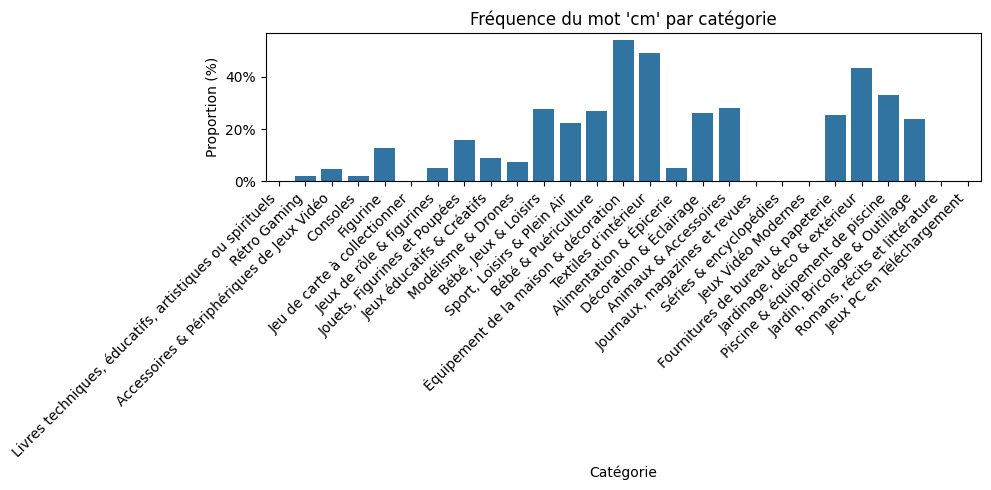

In [86]:
def plot_keyword_per_category(df, keyword, text_col="text"):
    pattern = fr"\b{re.escape(keyword)}\b"
    contains_word = df[text_col].str.contains(pattern, na=False)
    
    freq = (
        df.assign(contains_word=contains_word)
          .groupby("prdtypecode")["contains_word"]
          .mean()
          .reset_index()
    )
    
    freq["cat_label"] = freq["prdtypecode"].map(categories)
    freq["cat_label"] = freq["cat_label"].fillna(freq["prdtypecode"].astype(str))

    plt.figure(figsize=(10, 5))
    sns.barplot(data=freq, x="cat_label", y="contains_word")
    plt.title(f"Fréquence du mot '{keyword}' par catégorie")
    plt.ylabel("Proportion (%)")
    plt.xlabel("Catégorie")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_keyword_per_category(df, "cm")




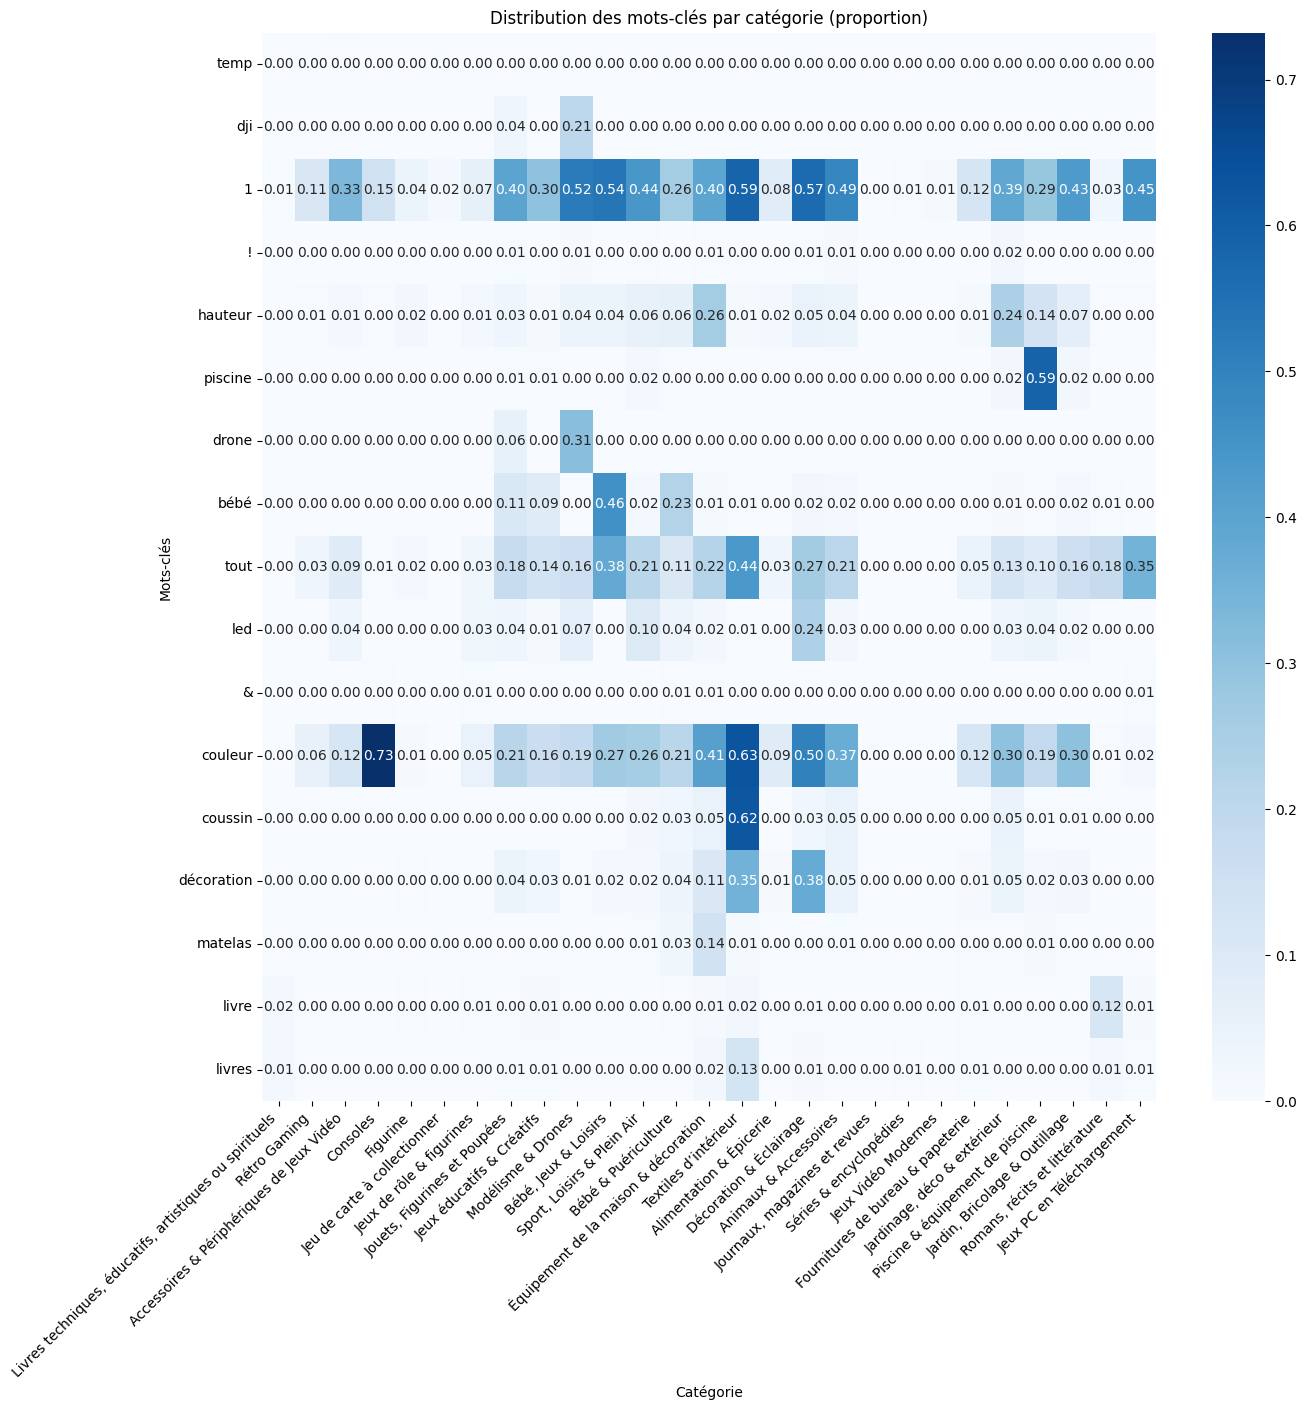

In [89]:
def plot_keywords_heatmap(df, keywords, text_col="text"):
    category_codes = sorted(df["prdtypecode"].unique())
    result = pd.DataFrame(index=keywords, columns=category_codes, dtype=float)
    for kw in keywords:
        pattern = fr"\b{re.escape(kw)}\b"
        contains_kw = df[text_col].astype(str).str.contains(pattern, na=False)
        freq = contains_kw.groupby(df["prdtypecode"]).mean()
        result.loc[kw, freq.index] = freq.values
    col_labels = [categories.get(code, str(code)) for code in category_codes]
    result_for_plot = result.copy()
    result_for_plot.columns = col_labels
    plt.figure(figsize=(14, len(keywords) * 0.6 + 4))
    sns.heatmap(result_for_plot.astype(float), annot=True, fmt=".2f", cmap="Blues")
    plt.title("Distribution des mots-clés par catégorie (proportion)")
    plt.xlabel("Catégorie")
    plt.ylabel("Mots-clés")
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

keywords = ["temp", "dji", "1", "!", "hauteur", 
            "piscine", "drone", "bébé", "tout",
            "led", "&", "couleur",
            "coussin", "décoration", "matelas", "livre", "livres",]

plot_keywords_heatmap(df, keywords)
